### Day 9 - Conv 2D
> Unlike the book, I'm going to implement convolution with arbitrary number of input and output channels

In [ ]:
import numpy as np
from PIL import Image
from pathlib import Path

In [ ]:
from lovely_numpy import Lo
from lovely_tensors import monkey_patch; monkey_patch()
from torch import Tensor
from torch.nn.functional import conv2d

In [ ]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
cuda.init()

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [ ]:
cu_file="day_09_conv2d.cu"

In [ ]:
#|output: asis
#|echo: false


c_code = Path(cu_file).read_text()
print(f'''

[{cu_file}](https://github.com/xl0/cuda-100/blob/master/nbs/{cu_file})

::: {{.code-block}}
```
{c_code}
```
:::
''')



[day_09_conv2d.cu](https://github.com/xl0/cuda-100/blob/master/nbs/day_09_conv2d.cu)

::: {.code-block}
```
#include <stdint.h>
#include <stdio.h>

/* 2D convolution, with padding to valid shape. Channel-first */
__global__ void conv2d_pad(float *in,
                           float *out,
                           float *filter,
                           int h,
                           int w,
                           int in_channels,
                           int out_channels,
                           int filter_size /* Must be an odd number */,
                           float pad) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int filter_r = (filter_size - 1) / 2;


    // In and Out data dimensions:
    // 0 - channel
    // 1 - height
    // 2 - width

    // Filter dimensions:
    // 0 - out channels
    // 1 - in channels
    // 2 - height
    // 3 - width

    // if (x == 0 && y == 0) {
    //     printf("h

In [ ]:
## Compiler options for more compile-time warnings.
warn_options=[
    '-Xcompiler', '-Wall',
    '-Xcompiler', '-Wextra',
    '-Xcompiler', '-Wsign-conversion',
    '-Xcompiler', '-Wcast-qual',
    '-Xcompiler', '-Wunused-parameter',
    '-Xcompiler', '-Wdouble-promotion',
    '-Xcompiler', '-Wformat=2',
    '-Xcompiler', '-Wfloat-equal',
    '-Xcompiler', '-Wshadow'
]

In [ ]:
def benchmark_conv2d_pad(ctx, kernel, input, filter, pad, block_size, grid_size, repeat=10, warmup=True):
    # input, channel-first
    # - Channel
    # - Height
    # - Width
    assert len(input.shape) == 3

    # Filter shape should be
    # - Out channels
    # - In  channels
    # - Height
    # - Width
    assert len(filter.shape) == 4

    in_ch, h, w = input.shape
    out_ch, in_ch2, fh, fw = filter.shape

    assert fh == fw, f"Only square filters supported, got shape={filter.shape}"

    assert in_ch == in_ch2

    out_shape = (out_ch, h, w)

    gpu_input = cuda.mem_alloc_like(input)
    gpu_filter = cuda.mem_alloc_like(filter)

    out = np.empty(out_shape, dtype=np.float32)

    cuda.memcpy_htod(gpu_input, input)
    cuda.memcpy_htod(gpu_filter, filter)
    ctx.synchronize()

    timing=0
    for _ in range(repeat):
        start = cuda.Event()
        end = cuda.Event()

        gpu_out = cuda.mem_alloc_like(out)

        if warmup:
            kernel(gpu_input, gpu_out, gpu_filter,
                   np.int32(h),
                   np.int32(w),
                   np.int32(in_ch),
                   np.int32(out_ch),
                   np.int32(fh),
                   np.float32(pad),
                   grid=grid_size,
                   block=block_size)
            ctx.synchronize()

        start.record()
        kernel(gpu_input, gpu_out, gpu_filter,
               np.int32(h),
               np.int32(w),
               np.int32(in_ch),
               np.int32(out_ch),
               np.int32(fh),
               np.float32(pad),
               grid=grid_size,
               block=block_size)
        end.record()
        end.synchronize()

        timing += end.time_since(start)
    timing /= repeat

    cuda.memcpy_dtoh(out, gpu_out)
    return out, timing;

array[3, 600, 451] f32 n=811800 (3.1Mb) x∈[0., 0.996] μ=0.592 σ=0.147


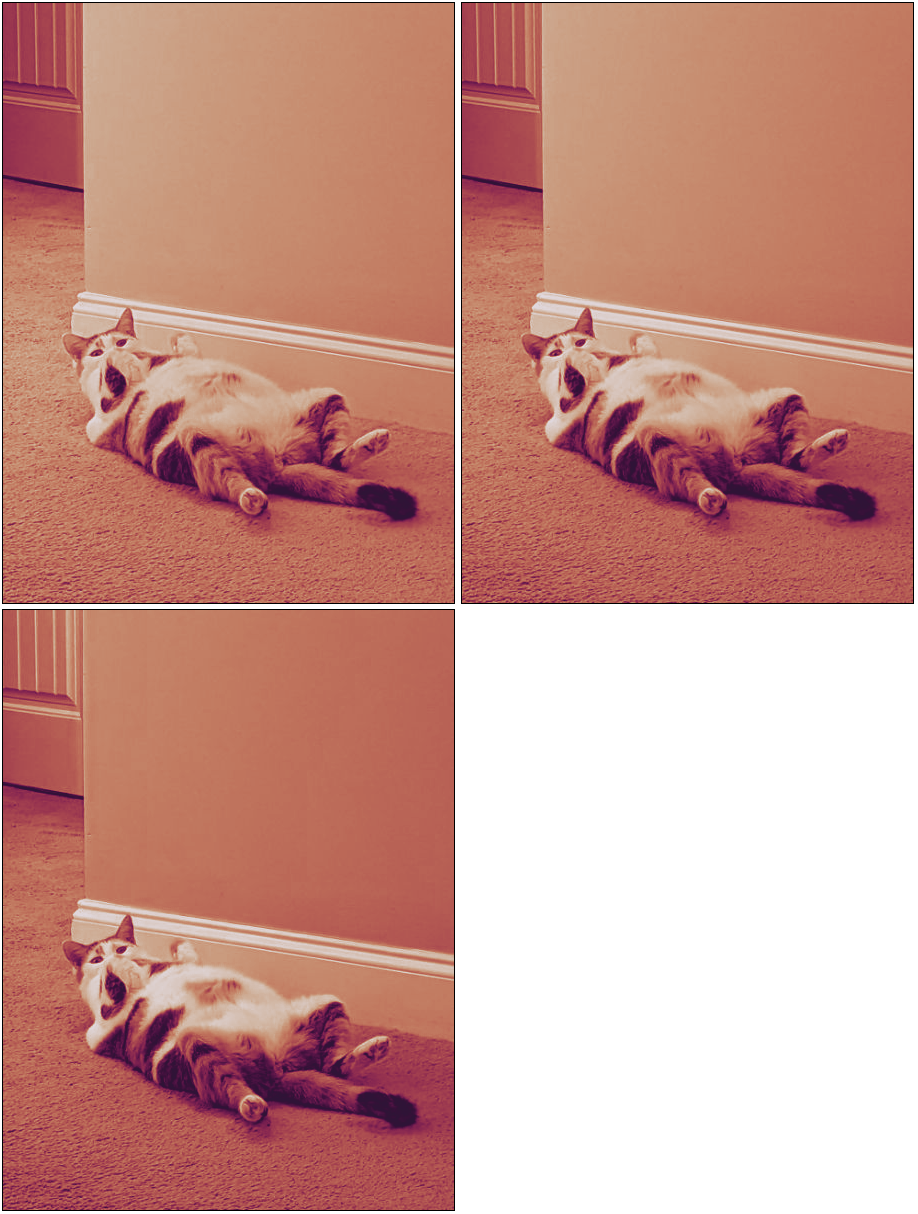

In [ ]:
input = Image.open("../cat-1.jpg")
input_array = np.ascontiguousarray(np.array(input).transpose(2, 0, 1)).astype(np.float32) / 256

# input_array = np.linspace(0, 0.5, 3*32*32).reshape(3, 32, 32).astype(np.float32) + 0.5

# Convert from HWC to CHW format
# input_array = np.ascontiguousarray(input_array.transpose(2, 0, 1))[:1,:,:]
print(Lo(input_array))
Lo(input_array).chans(cl=False)

In [ ]:
out_channels = 4
filter_size = 3

filter = np.random.randn(out_channels, input_array.shape[0], filter_size, filter_size).astype(np.float32) / 5

# This filter does nothing to the input image.
# filter = np.array([
#     [[[0, 0, 0],
#       [0, 1, 0],
#       [0, 0 ,0]]]
#     ]).astype(np.float32)


Lo(filter)

array[4, 3, 3, 3] f32 n=108 x∈[-0.754, 0.447] μ=0.020 σ=0.204

tensor[4, 600, 451] n=1082400 (4.1Mb) x∈[-0.401, 1.342] μ=0.306 σ=0.151


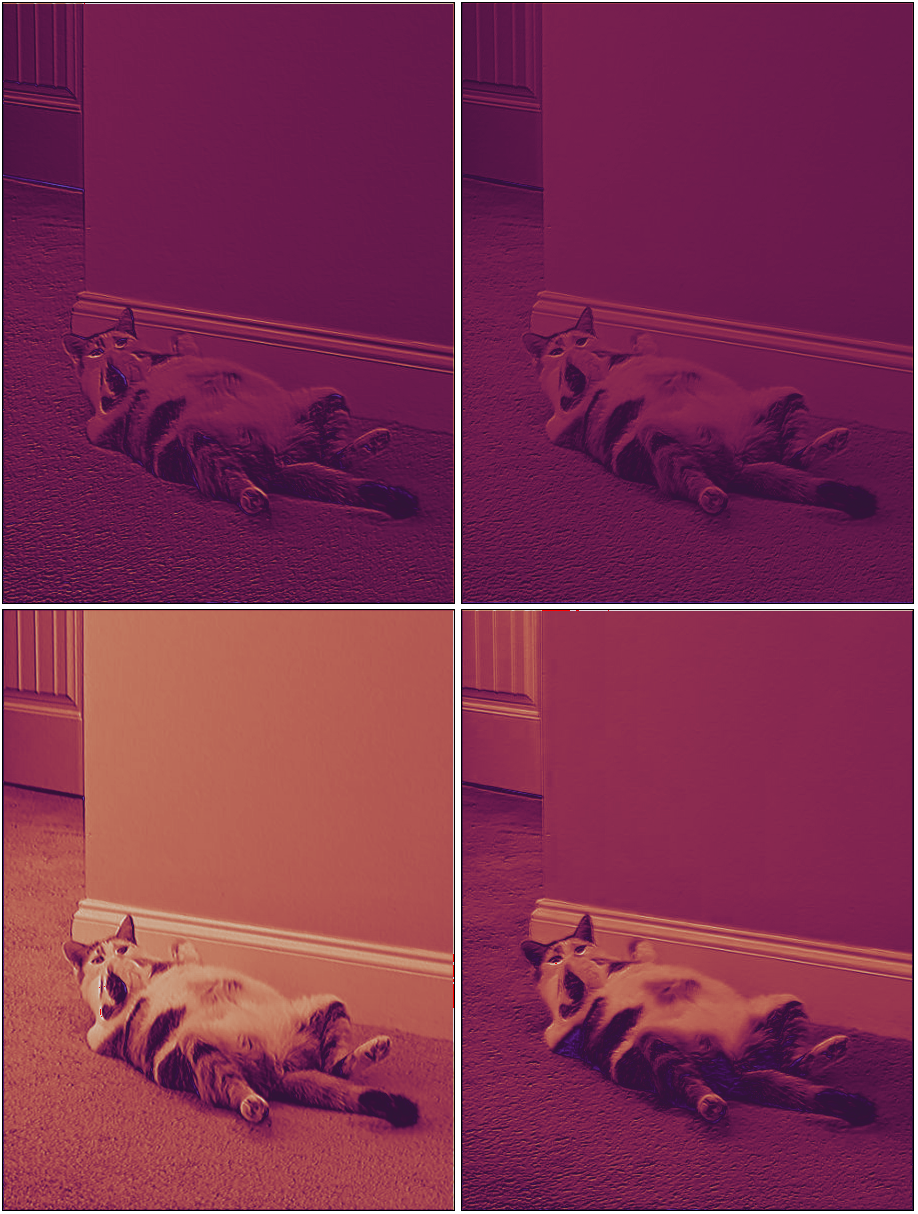

In [ ]:
# input_array = np.random.randn(3, 64,64).astype(np.float32)

torch_res = conv2d(Tensor(input_array), Tensor(filter), padding="same")
print(torch_res)
torch_res.chans(scale=1)

In [ ]:
tile_width = 32
ch, h, w = input_array.shape

ctx = device.make_context()
try:
    mod = SourceModule(
        Path(cu_file).read_text(),
        options=warn_options)

    kernel = mod.get_function("conv2d_pad")


    block_size = (tile_width,tile_width,1)
    grid_size = (
        ((w + tile_width - 1) // tile_width),
        ((h + tile_width - 1) // tile_width),
        1
    )


    print(f"Input shape: {input_array.shape}")
    print(f"Filter shape: {filter.shape}")
    print(f"Result shape: {(filter.shape[0], input_array.shape[1], input_array.shape[2])}")
    print(f"Grid size: {grid_size}")
    print(f"Block size: {block_size}")
    print(f"Total threads: {grid_size[0] * grid_size[1] * block_size[0] * block_size[1]}")


    res, timing = benchmark_conv2d_pad(ctx, kernel, input_array, filter, 0, block_size, grid_size, repeat=1, warmup=False)
finally:
    ctx.pop()
    ctx.detach()

print(Lo(res))
print(f"Took {timing:.3f}ms")

Input shape: (3, 600, 451)
Filter shape: (4, 3, 3, 3)
Result shape: (4, 600, 451)
Grid size: (15, 19, 1)
Block size: (32, 32, 1)
Total threads: 291840
array[4, 600, 451] f32 n=1082400 (4.1Mb) x∈[-0.401, 1.342] μ=0.306 σ=0.151
Took 0.142ms


In [ ]:
np.isclose(res, torch_res).mean()

np.float64(0.9994484478935698)

### Looks good!
I'll leave benchmarks and performance improvements for tomorrow.